# Denoising 2D Generated Datasets - classifier free guidance

In [ ]:
using Plots
using Flux
using BSON
using JSON
using StatsBase
using Printf

In [ ]:
using Revise
using DenoisingDiffusion 
using DenoisingDiffusion: train!

In [ ]:
include("datasets.jl");
includet("utilities.jl");

## Test

### load model

In [ ]:
directory = "../outputs/20221030_cond";
diffusion_path = joinpath(directory, "diffusion.bson");
history_path = joinpath(directory, "history.json");

In [ ]:
BSON.@load diffusion_path diffusion
println("data shape:    $(diffusion.data_shape)")
num_timesteps = diffusion.num_timesteps
println("num timesteps: $(num_timesteps)")
diffusion.denoise_fn

data shape:    (2,)
num timesteps: 40


ConditionalChain(
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(2 => 32),                     # 96 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 32),
      Dense(32 => 32),                  # 1_056 parameters
    ),
    Embedding(4 => 32),                 # 128 parameters
  ),
  NNlib.swish,
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(32 => 32),                    # 1_056 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 32),
      Dense(32 => 32),                  # 1_056 parameters
    ),
    Embedding(4 => 32),                 # 128 parameters
  ),
  NNlib.swish,
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(32 => 32),                    # 1_056 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 32),
      Dense(32 => 32),                  # 1_056 parameters
    ),
    Embedding(4 => 32),                 # 128 parameters
  ),
  NNlib.swish,
  Dense(32 => 2),                       # 66 paramet

In [ ]:
history = Dict()
open(history_path, "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 3 entries:
  "train_loss" => Any[1.04783, 0.976147, 0.953309, 0.938443, 0.928959, 0.93422,…
  "epoch_size" => 9000
  "val_loss"   => Any[1.03464, 0.940378, 0.955165, 0.935987, 0.986511, 0.939841…

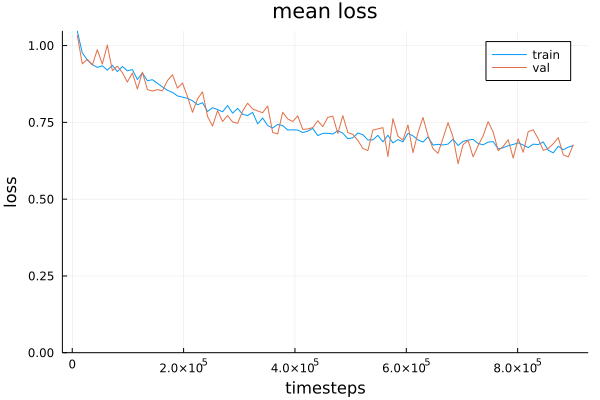

In [ ]:
timesteps = (1:length(history["train_loss"])) * history["epoch_size"]

p = plot(timesteps, history["train_loss"], 
    label="train", ylims=(0, Inf),
    title="mean loss",
    xlabel="timesteps",
    ylabel="loss",
)
plot!(p, timesteps, history["val_loss"], label="val")
savefig(p, joinpath(directory, "loss.png"))
p

### sample

In [ ]:
num_samples = 1000
x_gen = Dict{Int, Dict{Symbol, Array{Float32, 3}}}()
γ = 2.0f0
for label in 1:4
    X0s, X0_ests = p_sample_loop_all(diffusion, 1000, label; guidance_scale=γ, clip_denoised=false)
    x_gen[label] = Dict(
        :X0s => X0s,
        :X0_ests => X0_ests
    )
end

Sampling... 100%|████████████████████████████████████████| Time: 0:00:04
Sampling... 100%|████████████████████████████████████████| Time: 0:00:00
Sampling... 100%|████████████████████████████████████████| Time: 0:00:00
Sampling... 100%|████████████████████████████████████████| Time: 0:00:00


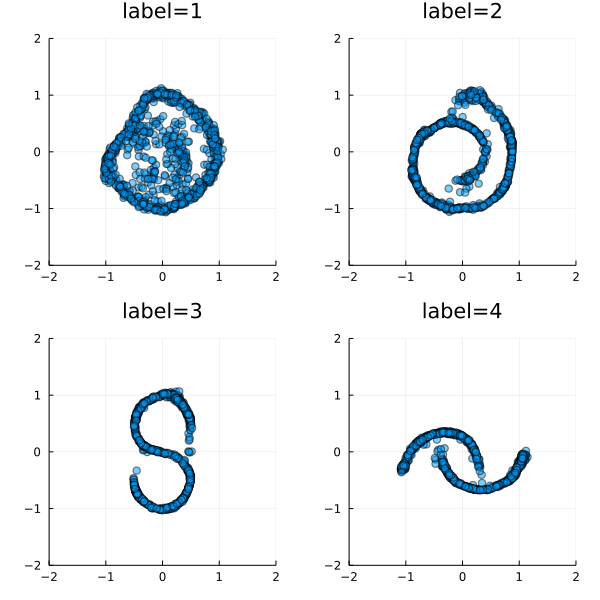

In [ ]:
canvases = []
for label in 1:4
    X0 = x_gen[label][:X0s][:, : , end]
    p0 = scatter(X0[1, :], X0[2, :], alpha=0.5, label="",
        aspectratio=:equal,
        xlims=(-2, 2), ylims=(-2, 2),
        title="label=$label",
        size=(600, 600),
    )
    push!(canvases, p0)
end
p = plot(canvases...)
savefig(p, joinpath(directory, "samples.png"))
p

### Animations 

In [ ]:
anim_denoise = @animate for i ∈ 1:(num_timesteps + 10)
   i = i > num_timesteps ? num_timesteps : i
    canvases = []
    for label in 1:4
        X0 = x_gen[label][:X0s][:, : , i]
        p0 = scatter(X0[1, :], X0[2, :], alpha=0.5, label="",
            aspectratio=:equal,
            xlims=(-2, 2), ylims=(-2, 2),
            title="label=$label",
            size=(600, 600),
        )
        push!(canvases, p0)
    end
    p = plot(canvases...)
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_VL84V8", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\20221030_cond\reverse.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\20221030_cond\\reverse.gif")
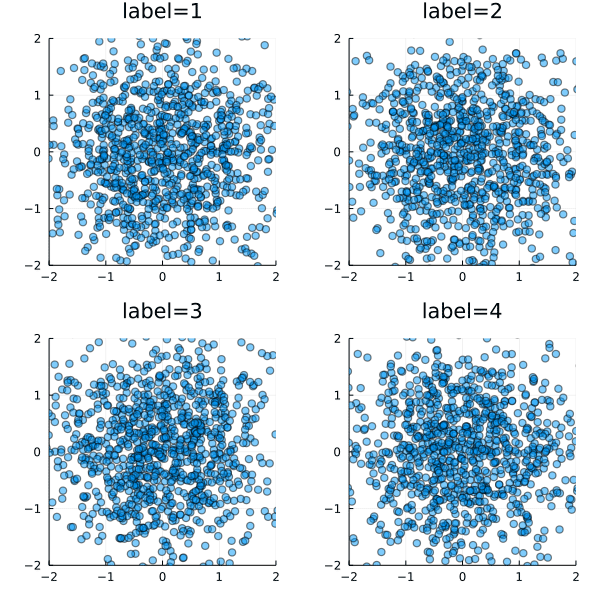

In [ ]:
gif(anim_denoise, joinpath(directory, "reverse.gif"), fps=8)

In [ ]:
anim_estimates = @animate for i ∈ 1:(num_timesteps + 10)
    i= i > num_timesteps ? num_timesteps : i
    canvases = []
    for label in 1:4
        X0_est = x_gen[label][:X0_ests][:, : , i]
        p0 = scatter(X0_est[1, :], X0_est[2, :], alpha=0.5, label="",
            aspectratio=:equal,
            xlims=(-2, 2), ylims=(-2, 2),
            title="label=$label",
            size=(600, 600),
        )
        push!(canvases, p0)
    end
    p = plot(canvases...)
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_qEhE4o", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\20221030_cond\estimates.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\20221030_cond\\estimates.gif")
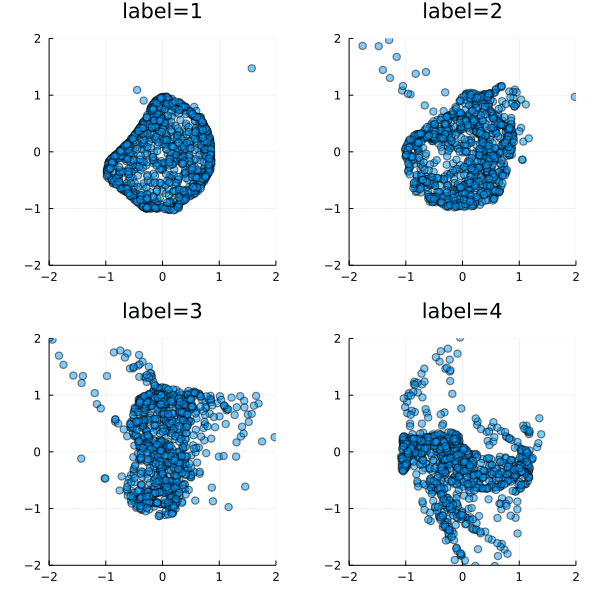

In [ ]:
gif(anim_estimates, joinpath(directory, "estimates.gif"), fps=8)